In [1]:
import requests

url = "https://raw.githubusercontent.com/silentrob/superscript-friends/master/transcripts/friends.txt"
response = requests.get(url)

with open("friends_script.txt", "w", encoding="utf-8") as f:
    f.write(response.text)

print("Archivo descargado como 'friends_script.txt'")


Archivo descargado como 'friends_script.txt'


In [2]:
# Leer el corpus, obtenemos unicamente los primero 250mil caracateres porque sino explota la RAM

with open("friends_script.txt", "r", encoding="utf-8") as f:
    text = f.read()

# Recortar a los primeros 250.000 caracteres
text = text[:250_000]

print(f"Longitud recortada del corpus: {len(text)} caracteres")
print(f"Primeros 500 caracteres:\n{text[:500]}")


Longitud recortada del corpus: 250000 caracteres
Primeros 500 caracteres:
Written by: Marta Kauffman & David Crane
Monica: There's nothing to tell! He's just some guy I work with!
Joey: C'mon, you're going out with the guy! There's gotta be something wrong with him!
Chandler: All right Joey, be nice.  So does he have a hump? A hump and a hairpiece?
Phoebe: Wait, does he eat chalk?
Phoebe: Just, 'cause, I don't want her to go through what I went through with Carl- oh!
Monica: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- 


In [3]:
import re
import unicodedata

def clean_raw_text(txt):
    txt = re.sub(r" +", " ", txt)
    txt = re.sub(r"\[.*?\]", "", txt)
    txt = re.sub(r"\(.*?\)", "", txt)
    txt = "\n".join([line for line in txt.splitlines() if line.strip() != ""])
    txt = re.sub(r"^(\w+):", lambda m: m.group(1).lower() + ":", txt, flags=re.M)
    return txt

def normalize_text(txt):
    txt = txt.lower()
    txt = unicodedata.normalize("NFD", txt)
    txt = txt.encode("ascii", "ignore").decode("utf-8")
    txt = re.sub(r"[^a-z0-9.,!?'\\n:;()\" \\-]+", '', txt)
    return txt

In [4]:
text = clean_raw_text(text)
text = normalize_text(text)

In [5]:
# Crear vocabulario y mappings
chars = sorted(set(text))
vocab_size = len(chars)
print(f"Vocabulario: {vocab_size} caracteres")

# Mapeo de caracteres a índices y viceversa
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# Vectorizar todo el texto
encoded_text = [char_to_idx[c] for c in text]

Vocabulario: 48 caracteres


In [6]:
import numpy as np
# Longitud de contexto (many-to-many)
max_context_size = 100  # secuencias de entrada y salida de esta longitud

# Separar el texto tokenizado en entrenamiento y validación
p_val = 0.1
num_val = int(np.ceil(len(encoded_text) * p_val / max_context_size))

train_text = encoded_text[:-num_val * max_context_size]
val_text = encoded_text[-num_val * max_context_size:]

# Generar secuencias de entrenamiento y validación

tokenized_sentences_train = [train_text[i:i + max_context_size] for i in range(len(train_text) - max_context_size + 1)]
tokenized_sentences_val = [val_text[i:i + max_context_size] for i in range(num_val)]

# Dataset de entrenamiento (many-to-many): shift de una posición
X_train = np.array(tokenized_sentences_train[:-1])
y_train = np.array(tokenized_sentences_train[1:])

# Dataset de validación
X_val = np.array(tokenized_sentences_val[:-1])
y_val = np.array(tokenized_sentences_val[1:])

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val: {X_val.shape}, {y_val.shape}")

Train: (220008, 100), (220008, 100)
Val: (244, 100), (244, 100)


In [7]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

In [8]:
from keras.callbacks import Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

class PplCallback(Callback):
    def __init__(self, val_data, history_ppl, patience=5):
        self.val_data = val_data
        self.target = []
        self.padded = []
        self.info = []
        self.min_score = np.inf
        self.patience = patience
        self.patience_counter = 0
        self.history_ppl = history_ppl
        count = 0

        for seq in self.val_data:
            len_seq = len(seq)
            subseq = [seq[:i] for i in range(1, len_seq)]
            self.target.extend([seq[i] for i in range(1, len_seq)])
            if len(subseq) > 0:
                padded_seqs = pad_sequences(subseq, maxlen=max_context_size, padding='pre')
                self.padded.append(padded_seqs)
                self.info.append((count, count + len_seq - 1))
                count += len_seq - 1

        self.padded = np.vstack(self.padded)

    def on_epoch_end(self, epoch, logs=None):
        scores = []
        predictions = self.model.predict(self.padded, verbose=0)

        for start, end in self.info:
            local_probs = []
            for i in range(start, end):
                if i >= len(predictions):
                    break
                if self.target[i] >= predictions.shape[2]:
                    continue
                prob = predictions[i, -1, self.target[i]]
                prob = max(prob, 1e-8)  )
                local_probs.append(prob)

            if local_probs:
                scores.append(np.exp(-np.sum(np.log(local_probs)) / len(local_probs)))

        if scores:
            current_score = np.mean(scores)
            self.history_ppl.append(current_score)
            print(f'\n Perplejidad media: {current_score:.4f}')

            if current_score < self.min_score:
                self.min_score = current_score
                self.model.save("my_model.keras")
                print("Nuevo modelo guardado.")
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.patience:
                    print("Early stopping activado.")
                    self.model.stop_training = True


### SimpleRNN

In [ ]:
from keras.models import Sequential
from keras.layers import TimeDistributed, CategoryEncoding, SimpleRNN, Dense

model = Sequential()
model.add(TimeDistributed(
    CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"),
    input_shape=(None, 1))
)
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 48)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        49,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 48)       │         9,648 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,448 (232.22 KB)

 Trainable params: 59,448 (232.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
history_ppl = []

hist = model.fit(
    X_train[..., np.newaxis],
    y_train[..., np.newaxis],
    epochs=20,
    batch_size=254,
    callbacks=[PplCallback(tokenized_sentences_val, history_ppl)],
    verbose=1,
    shuffle=True
)


Epoch 1/20
3435/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5701
 Perplejidad media: 5.4521
Nuevo modelo guardado.
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 1.5701
Epoch 2/20
3437/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5545
 Perplejidad media: 5.1467
Nuevo modelo guardado.
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 1.5545
Epoch 3/20
3437/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5418
 Perplejidad media: 5.2056
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 1.5418
Epoch 4/20
3436/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5340
 Perplejidad media: 5.1213
Nuevo modelo guardado.
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 1.5340
Epoch 5/20
3435/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5284
 Perplejidad media: 5.2846
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - loss: 1.5284
Epoch 6/20
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5237
 Perplejidad media: 5.1787
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - lo

In [ ]:
import json

history_ppl_float = [float(x) for x in history_ppl]

with open("perplejidad_history.json", "w") as f:
    json.dump(history_ppl_float, f)

from google.colab import files
files.download("perplejidad_history.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

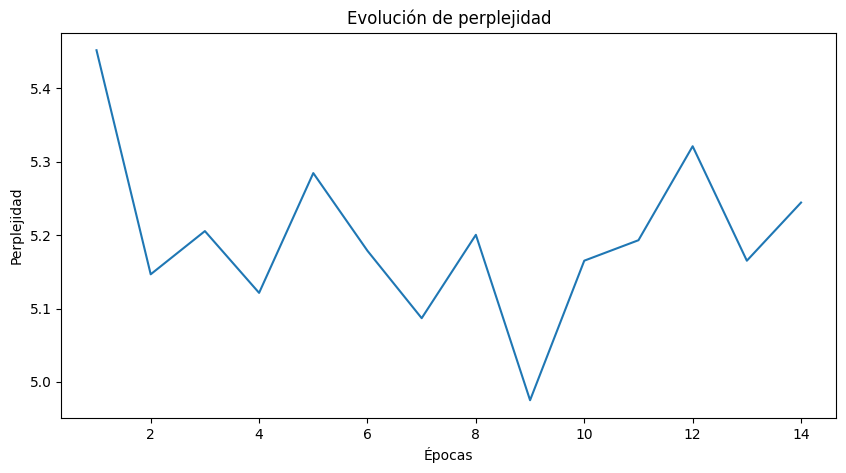

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, len(history_ppl)+1), y=history_ppl)
plt.xlabel("Épocas")
plt.ylabel("Perplejidad")
plt.title("Evolución de perplejidad")
plt.show()

### LSTM y GRU

In [9]:
# Hiperparametros
embedding_dim = 64
hidden_units = 200
dropout = 0.1
batch_size = 64
epochs = 20

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Longitud de contexto fija
max_context_size = 30

# =====================
# ENTRENAMIENTO
# =====================

X_train = []
y_train = []

for seq in tokenized_sentences_train:
    if len(seq) < 2:
        continue
    X_train.append(seq[:-1])
    y_train.append(seq[1:])

X_train = pad_sequences(X_train, maxlen=max_context_size, padding='pre')
y_train = pad_sequences(y_train, maxlen=max_context_size, padding='pre')

X_train = np.array(X_train)
y_train = np.array(y_train)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# =====================
# VALIDACION
# =====================

X_val = []
y_val = []

for seq in tokenized_sentences_val:
    if len(seq) < 2:
        continue
    X_val.append(seq[:-1])
    y_val.append(seq[1:])

X_val = pad_sequences(X_val, maxlen=max_context_size, padding='pre')
y_val = pad_sequences(y_val, maxlen=max_context_size, padding='pre')

X_val = np.array(X_val)
y_val = np.array(y_val)

print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (220009, 30)
y_train shape: (220009, 30)
X_val shape: (245, 30)
y_val shape: (245, 30)


#### LSTM

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_context_size))
model_lstm.add(LSTM(hidden_units, return_sequences=True, dropout=dropout))
model_lstm.add(Dense(vocab_size, activation='softmax'))

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_lstm.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
from google.colab import drive
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Montar Google Drive
drive.mount('/content/drive')

# Ruta Drive
output_path = "/content/drive/MyDrive/mejor_modelo_lstm.keras"

# Callback para guardar el mejor modelo según val_loss
checkpoint_lstm = ModelCheckpoint(
    output_path,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# Early stop
early_stop_lstm = EarlyStopping(
    patience=4,
    restore_best_weights=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# Entrenamiento con callbacks
history_ppl = []

model_lstm.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=64,
    shuffle=True,
    validation_data=(X_val, y_val),
    callbacks=[
        PplCallback(tokenized_sentences_val, history_ppl),
        early_stop_lstm,
        checkpoint_lstm
    ],
    verbose=1
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/20
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 2.2142
 Perplejidad media: 6.0800
Nuevo modelo guardado.

Epoch 1: val_loss improved from inf to 1.80393, saving model to /content/drive/MyDrive/mejor_modelo_lstm.keras
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 345s 100ms/step - loss: 2.2141 - val_loss: 1.8039
Epoch 2/20
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.5353
 Perplejidad media: 5.5597
Nuevo modelo guardado.

Epoch 2: val_loss improved from 1.80393 to 1.70094, saving model to /content/drive/MyDrive/mejor_modelo_lstm.keras
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 339s 99ms/step - loss: 1.5353 - val_loss: 1.7009
Epoch 3/20
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 1.4224
 Perplejidad media: 5.3008
Nuevo modelo guardado.

Epoch 3: val_loss improved from 1.70094 to 1.64473, saving model to /content/drive/MyDrive/mejor_modelo_lstm.keras
3438/3

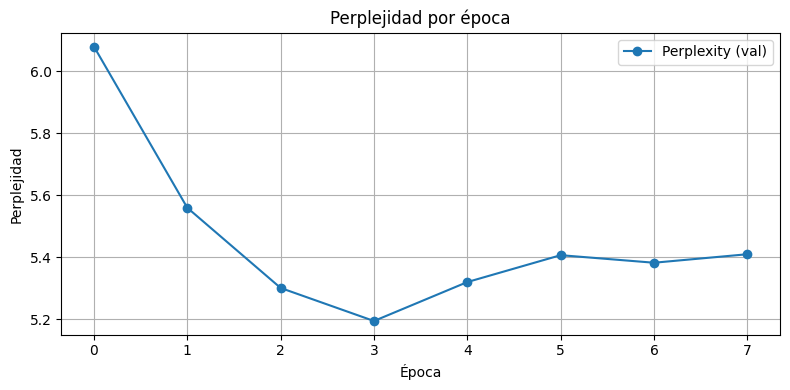

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history_ppl, marker='o', label='Perplexity (val)')
plt.title('Perplejidad por época')
plt.xlabel('Época')
plt.ylabel('Perplejidad')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### GRU

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense
from keras.optimizers import Adam

# Hiperparametros
embedding_dim = 128
hidden_units = 256
dropout = 0.2
recurrent_dropout = 0.1


model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_context_size))
model_gru.add(GRU(hidden_units, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
model_gru.add(Dense(vocab_size, activation='softmax'))

# Compilar con un optimizador Adam
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001))
model_gru.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Guardado autom
checkpoint = ModelCheckpoint(
    "mejor_modelo_gru.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# Early stop
early_stop = EarlyStopping(
    patience=4,
    restore_best_weights=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

history_ppl_gru = []

model_gru.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=64,
    shuffle=True,
    validation_data=(X_val, y_val),
    callbacks=[
        PplCallback(tokenized_sentences_val, history_ppl_gru),
        early_stop,
        checkpoint
    ],
    verbose=1
)

Epoch 1/20
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 1.8097
 Perplejidad media: 4.5917
Nuevo modelo guardado.

Epoch 1: val_loss improved from inf to 1.53119, saving model to mejor_modelo_gru.keras
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 382s 96ms/step - loss: 1.8096 - val_loss: 1.5312
Epoch 2/20
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.2763
 Perplejidad media: 4.6736

Epoch 2: val_loss did not improve from 1.53119
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 380s 95ms/step - loss: 1.2763 - val_loss: 1.5369
Epoch 3/20
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.2244
 Perplejidad media: 4.7151

Epoch 3: val_loss did not improve from 1.53119
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 383s 96ms/step - loss: 1.2244 - val_loss: 1.5470
Epoch 4/20
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.2006
 Perplejidad media: 4.5839
Nuevo modelo guardado.

Epoch 4: val_loss improved from 1.53119 to 1.51707, saving model to mejor_modelo_gru.keras
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 387s 97ms/step - lo

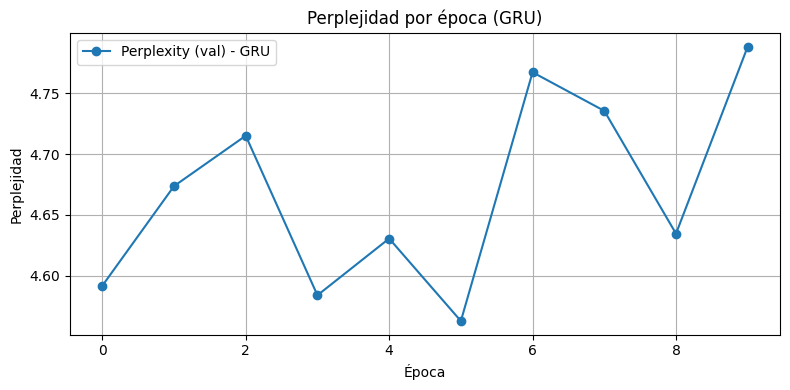

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history_ppl_gru, marker='o', label='Perplexity (val) - GRU')
plt.title('Perplejidad por época (GRU)')
plt.xlabel('Época')
plt.ylabel('Perplejidad')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Genereacion de texto

Se tomo model_lstm para hacer una prueba de generacion de texto. Luego de correrlo varias veces fue el que mas estable se compartó en teminos de perplexity y evolucionó mejor a lo largo de las epochs.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
from tensorflow.keras.models import load_model

model_lstm = load_model("/content/drive/MyDrive/mejor_modelo_lstm.keras")
print("Modelo LSTM cargado")


Modelo LSTM cargado


In [21]:
import numpy as np

def sample_with_temperature(probabilities, temperature=1.0):
    probabilities = np.asarray(probabilities).astype("float64")
    probabilities = np.log(probabilities + 1e-8) / temperature
    exp_probs = np.exp(probabilities)
    probabilities = exp_probs / np.sum(exp_probs)
    return np.random.choice(len(probabilities), p=probabilities)

def generate_text(model, seed_text, max_len=100, temperature=1.0, beam_width=1):
    input_seq = [char_to_idx.get(c, 0) for c in seed_text]
    input_seq = input_seq[-max_context_size:]

    if beam_width == 1:
        # Greedy/Sampling
        for _ in range(max_len):
            padded = np.array([input_seq[-max_context_size:]])
            padded = np.pad(padded, ((0, 0), (max_context_size - len(padded[0]), 0)), mode='constant')
            preds = model.predict(padded, verbose=0)[0][-1]
            next_token = sample_with_temperature(preds, temperature)
            input_seq.append(next_token)
        return "".join(idx_to_char.get(i, "") for i in input_seq)

    else:
        # Beam Search
        sequences = [[input_seq, 0.0]]
        for _ in range(max_len):
            all_candidates = []
            for seq, score in sequences:
                padded = np.array([seq[-max_context_size:]])
                padded = np.pad(padded, ((0, 0), (max_context_size - len(padded[0]), 0)), mode='constant')
                preds = model.predict(padded, verbose=0)[0][-1]
                top_tokens = np.argsort(preds)[-beam_width:]
                for t in top_tokens:
                    candidate = [seq + [t], score - np.log(preds[t] + 1e-8)]
                    all_candidates.append(candidate)
            sequences = sorted(all_candidates, key=lambda tup: tup[1])[:beam_width]
        best = sequences[0][0]
        return "".join(idx_to_char.get(i, "") for i in best)

In [22]:
seed = "monica said"

print("Greedy:")
print(generate_text(model_lstm, seed_text=seed, temperature=1.0, beam_width=1))
print()

print("Beam Search (beam_width=3):")
print(generate_text(model_lstm, seed_text=seed, beam_width=3))
print()

print("Sampling con temperatura alta (1.5):")
print(generate_text(model_lstm, seed_text=seed, temperature=1.5, beam_width=1))


Greedy:
monica said barry in a heads out peast, who alpare recay having my mainet small. barry: why don't-mas.phoebe: o

Beam Search (beam_width=3):
monica said you think you want to think you wanna be that things what you're gonna be that things what you know

Sampling con temperatura alta (1.5):
monica said kist eagesre.david: that's back?)axd bedtisn't. joey: oh stil: okay?cuh! rigge kindpuff.ross: pritt


### Analisis de resultados

Se entreno un modelo LSTM con corpus de Friends utilizando entrenamiento many-to-many con secuencias de 30 caracteres. Se evaluaron tres estrategias de generacion de texto:

- **Greedy Search**: produce resultados coherentes a nivel gramatical, pero repetitivos y poco creativos.
- **Beam Search (beam width = 3)**: logra mayor coherencia y repeticion de estructuras, pero tiende a frases redundantes.
- **Sampling con temperatura alta (1.5)**: genera textos mas variados pero con mayor ruido y menos coherencia.

En conjunto, se observa que el modelo capta patrones del lenguaje del corpus, aunque la calidad de los resultados depende fuertemente de la estrategia de decodificacion.
